In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import os

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import warnings
warnings.filterwarnings('ignore')
print("Ingore......")

Ingore......


In [4]:
bad_sperm_path = 'sperm-morphological-quality/Sperm-Data/High Quality Sperm - Labeled/Bad Sperm'
good_sperm_path = 'sperm-morphological-quality/Sperm-Data/High Quality Sperm - Labeled/Good Sperm'

In [5]:
bad_sperm_count = len(os.listdir(bad_sperm_path))
good_sperm_count = len(os.listdir(good_sperm_path))

In [6]:
data = pd.DataFrame({
    'Category': ['Bad Sperm', 'Good Sperm'],
    'Count': [bad_sperm_count, good_sperm_count]
})

In [7]:
data

,Category,Count
0,Bad Sperm,3656
1,Good Sperm,486


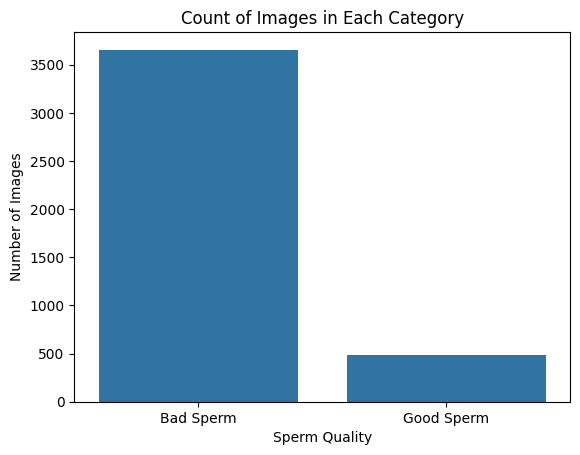

In [8]:
sns.barplot(x='Category', y='Count', data=data)
plt.title('Count of Images in Each Category')
plt.xlabel('Sperm Quality')
plt.ylabel('Number of Images')
plt.show()

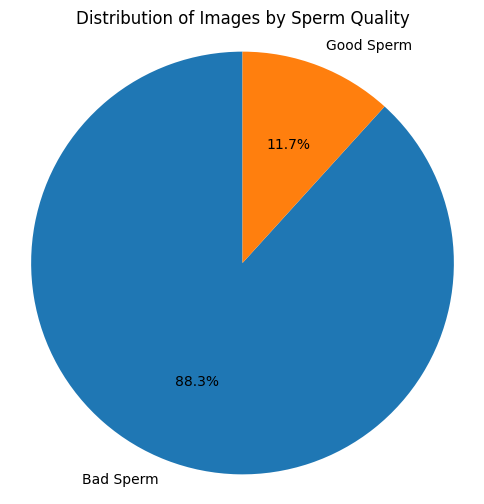

In [9]:
plt.figure(figsize=(6, 6))
plt.pie(data['Count'], labels=data['Category'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Images by Sperm Quality')
plt.axis('equal')  
plt.show()

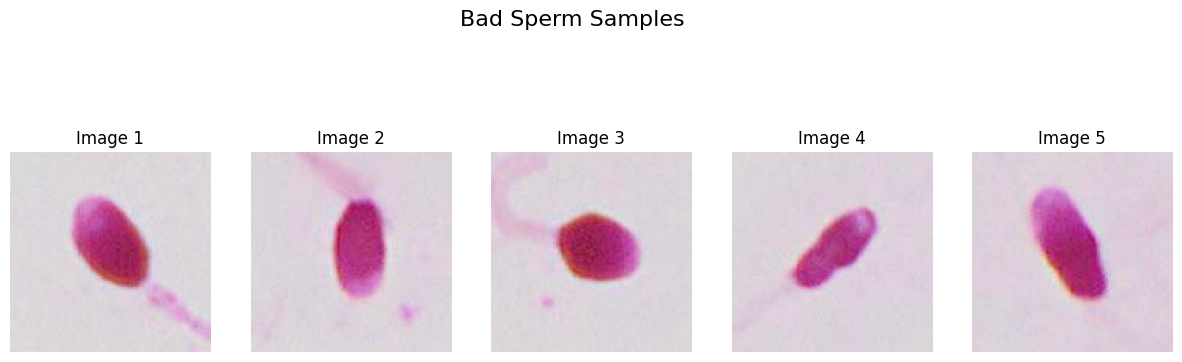

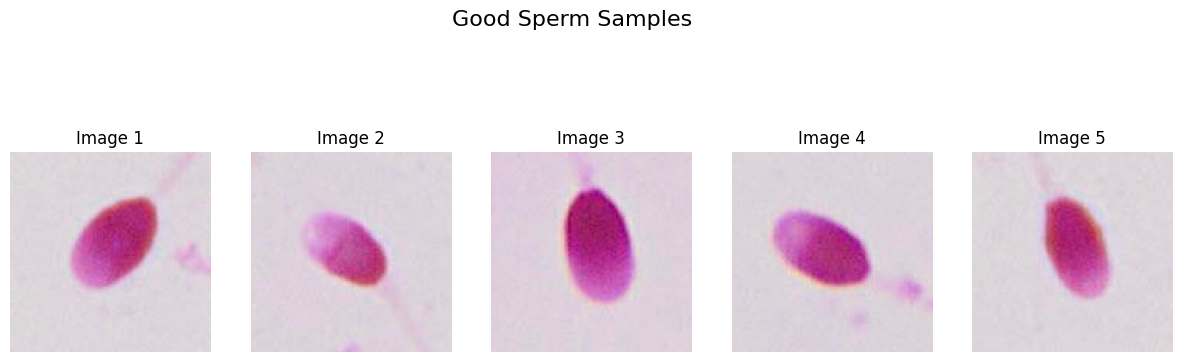

In [10]:
def display_images_from_folder(folder_path, num_images=5, title=""):
    image_files = os.listdir(folder_path)[:num_images]
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i + 1}")

    plt.show()

display_images_from_folder(bad_sperm_path, num_images=5, title="Bad Sperm Samples")

display_images_from_folder(good_sperm_path, num_images=5, title="Good Sperm Samples")

In [11]:
bad_sperm_images = [os.path.join(bad_sperm_path, img) for img in os.listdir(bad_sperm_path)]
good_sperm_images = [os.path.join(good_sperm_path, img) for img in os.listdir(good_sperm_path)]

bad_sperm_df = pd.DataFrame({
    'file_path': bad_sperm_images,
    'label': 'bad_sperm'
})

good_sperm_df = pd.DataFrame({
    'file_path': good_sperm_images,
    'label': 'good_sperm'
})

In [12]:
combined_df = pd.concat([bad_sperm_df, good_sperm_df], ignore_index=True)

In [13]:
combined_df 

,file_path,label
0,sperm-morphological-quality/Sperm-Data/High Qu...,bad_sperm
1,sperm-morphological-quality/Sperm-Data/High Qu...,bad_sperm
2,sperm-morphological-quality/Sperm-Data/High Qu...,bad_sperm
3,sperm-morphological-quality/Sperm-Data/High Qu...,bad_sperm
4,sperm-morphological-quality/Sperm-Data/High Qu...,bad_sperm
...,...,...
4137,sperm-morphological-quality/Sperm-Data/High Qu...,good_sperm
4138,sperm-morphological-quality/Sperm-Data/High Qu...,good_sperm
4139,sperm-morphological-quality/Sperm-Data/High Qu...,good_sperm
4140,sperm-morphological-quality/Sperm-Data/High Qu...,good_sperm


In [14]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(combined_df[['file_path']], combined_df['label'])

balanced_train_df = pd.DataFrame({
    'filepaths': X_resampled['file_path'],
    'labels': y_resampled
})

In [15]:
balanced_train_df

,filepaths,labels
0,sperm-morphological-quality/Sperm-Data/High Qu...,bad_sperm
1,sperm-morphological-quality/Sperm-Data/High Qu...,bad_sperm
2,sperm-morphological-quality/Sperm-Data/High Qu...,bad_sperm
3,sperm-morphological-quality/Sperm-Data/High Qu...,bad_sperm
4,sperm-morphological-quality/Sperm-Data/High Qu...,bad_sperm
...,...,...
7307,sperm-morphological-quality/Sperm-Data/High Qu...,good_sperm
7308,sperm-morphological-quality/Sperm-Data/High Qu...,good_sperm
7309,sperm-morphological-quality/Sperm-Data/High Qu...,good_sperm
7310,sperm-morphological-quality/Sperm-Data/High Qu...,good_sperm


In [16]:
train_df, temp_df = train_test_split(balanced_train_df, test_size=0.2, stratify=balanced_train_df['labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 5849
Validation set size: 731
Test set size: 732


In [17]:
IMAGE_SIZE = (224, 224)  
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5849 validated image filenames belonging to 2 classes.
Found 731 validated image filenames belonging to 2 classes.
Found 732 validated image filenames belonging to 2 classes.


In [18]:
print("Class indices (0: bad_sperm, 1: good_sperm):", train_generator.class_indices)

Class indices (0: bad_sperm, 1: good_sperm): {'bad_sperm': 0, 'good_sperm': 1}


In [19]:
class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, image_size=(224, 224), shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[indexes]

        return self.__data_generation(batch_data)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_data):
        X = np.empty((self.batch_size, *self.image_size, 3))  
        y = np.empty((self.batch_size, *self.image_size, 1))  

        for i, row in enumerate(batch_data.itertuples()):
            image = cv2.imread(row.filepaths)  
            image = cv2.resize(image, self.image_size)
            X[i] = image / 255.0  # Normalize the image

            # Convert label to binary format
            label = 1 if row.labels == 'Good Sperm' else 0
            y[i] = np.full((self.image_size[0], self.image_size[1], 1), label)  # Fill with label value
            
        return X, y

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_generator = DataGenerator(train_df, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
validation_generator = DataGenerator(val_df, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

In [20]:
def build_unet(input_size=(224, 224, 3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (224, 224, 3) 
unet = build_unet(input_shape)

unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

In [22]:
history = unet.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
182/182 ━━━━━━━━━━━━━━━━━━━━ 6572s 36s/step - accuracy: 0.9684 - loss: 0.0435 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
182/182 ━━━━━━━━━━━━━━━━━━━━ 7271s 40s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
182/182 ━━━━━━━━━━━━━━━━━━━━ 6226s 34s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
182/182 ━━━━━━━━━━━━━━━━━━━━ 20986s 116s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
182/182 ━━━━━━━━━━━━━━━━━━━━ 5882s 32s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


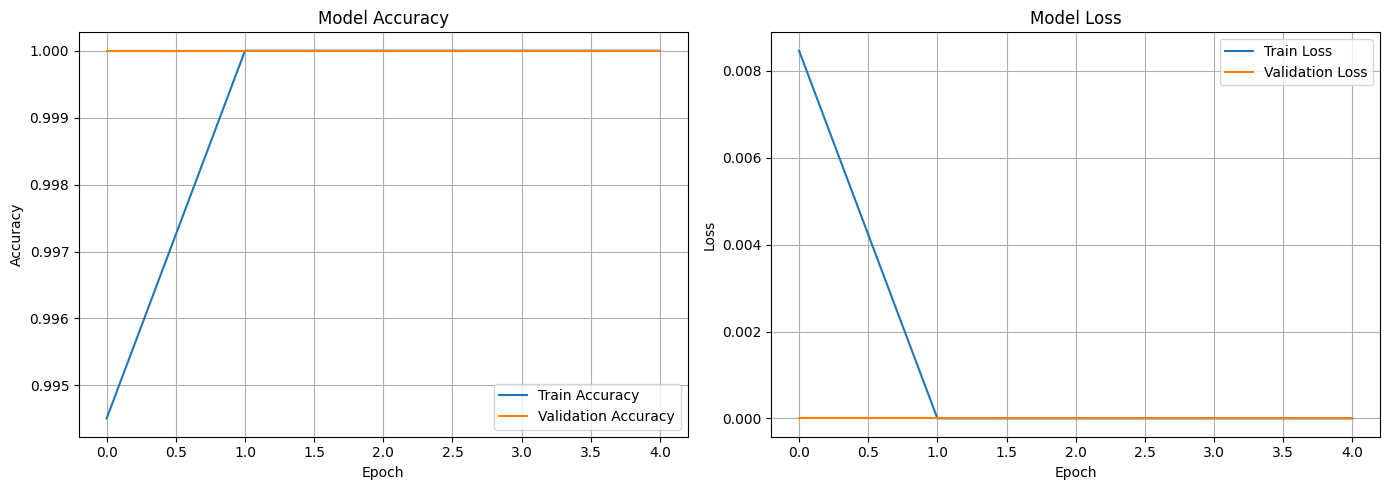

In [23]:
def plot_training_history(history):
    
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_training_history(history)